In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Load the formatted Millard datasets
df_1 = pd.read_csv("Millard_data_1mM_formated.csv")
df_10 = pd.read_csv("Millard_data_10mM_formated.csv")
df_30 = pd.read_csv("Millard_data_30mM_formated.csv")

# Load Paul media to get the full set of metabolites
paul_media = pd.read_csv("Paul_media.csv")
paul_metabolites = list(paul_media.columns[1:])  # exclude 'ID'

# Assign IDs for Millard datasets
id_map = {1: 1, 10: 2, 30: 3}
dfs = {1: df_1, 2: df_10, 3: df_30}

media_rows = []
od_df_combined = pd.DataFrame()

for label, df in dfs.items():
    initial = df.iloc[0]
    
    # Build the media row from initial concentrations
    media_dict = {
        'ID': label,
        'glc__D_e': initial['GLC'],
        'acet_e': initial['ACE_env'],
        'accoa_c': initial['ACCOA'],
        'acp_c': initial['ACP'],
        'ac_c': initial['ACE_cell'],
    }

    # Fill in other required metabolites with 0
    for met in paul_metabolites:
        if met not in media_dict:
            media_dict[met] = 0.0
    media_rows.append(media_dict)

    # Create OD block for each condition
    t_col = f'T_{label}'
    od_col = f'OD_{label}'
    dev_col = f'DEV_{label}'

    tmp_df = pd.DataFrame({
        t_col: df['T'],
        od_col: np.log(df['X'] + 1e-8),  # log-transform def: 1e-8
        dev_col: np.zeros_like(df['X'])  # no deviation data
    })

    # force to match expected row count (padding to 20 rows)
    while len(tmp_df) < 20:
        tmp_df.loc[len(tmp_df)] = [np.nan, np.nan, np.nan]

    tmp_df.reset_index(drop=True, inplace=True)
    od_df_combined = pd.concat([od_df_combined, tmp_df], axis=1)


In [2]:
od_df_combined

,T_1,OD_1,DEV_1,T_2,OD_2,DEV_2,T_3,OD_3,DEV_3
0,0.000000e+00,-2.65926,0.0,0.000000e+00,-2.701018,0.0,0.000000e+00,-2.627399,0.0
1,9.580000e-09,-2.65926,0.0,2.860101e-08,-2.701018,0.0,4.274003e-07,-2.627398,0.0
2,1.920000e-08,-2.65926,0.0,5.720201e-08,-2.701018,0.0,5.025253e-07,-2.627398,0.0
3,3.830000e-08,-2.65926,0.0,1.072459e-07,-2.701018,0.0,5.776502e-07,-2.627398,0.0
4,5.750000e-08,-2.65926,0.0,1.572897e-07,-2.701018,0.0,6.640391e-07,-2.627398,0.0
...,...,...,...,...,...,...,...,...,...
98,NaN,NaN,NaN,NaN,NaN,NaN,5.689341e+00,0.208527,0.0
99,NaN,NaN,NaN,NaN,NaN,NaN,5.692905e+00,0.209606,0.0
100,NaN,NaN,NaN,NaN,NaN,NaN,5.696470e+00,0.210685,0.0
101,NaN,NaN,NaN,NaN,NaN,NaN,5.712930e+00,0.215681,0.0


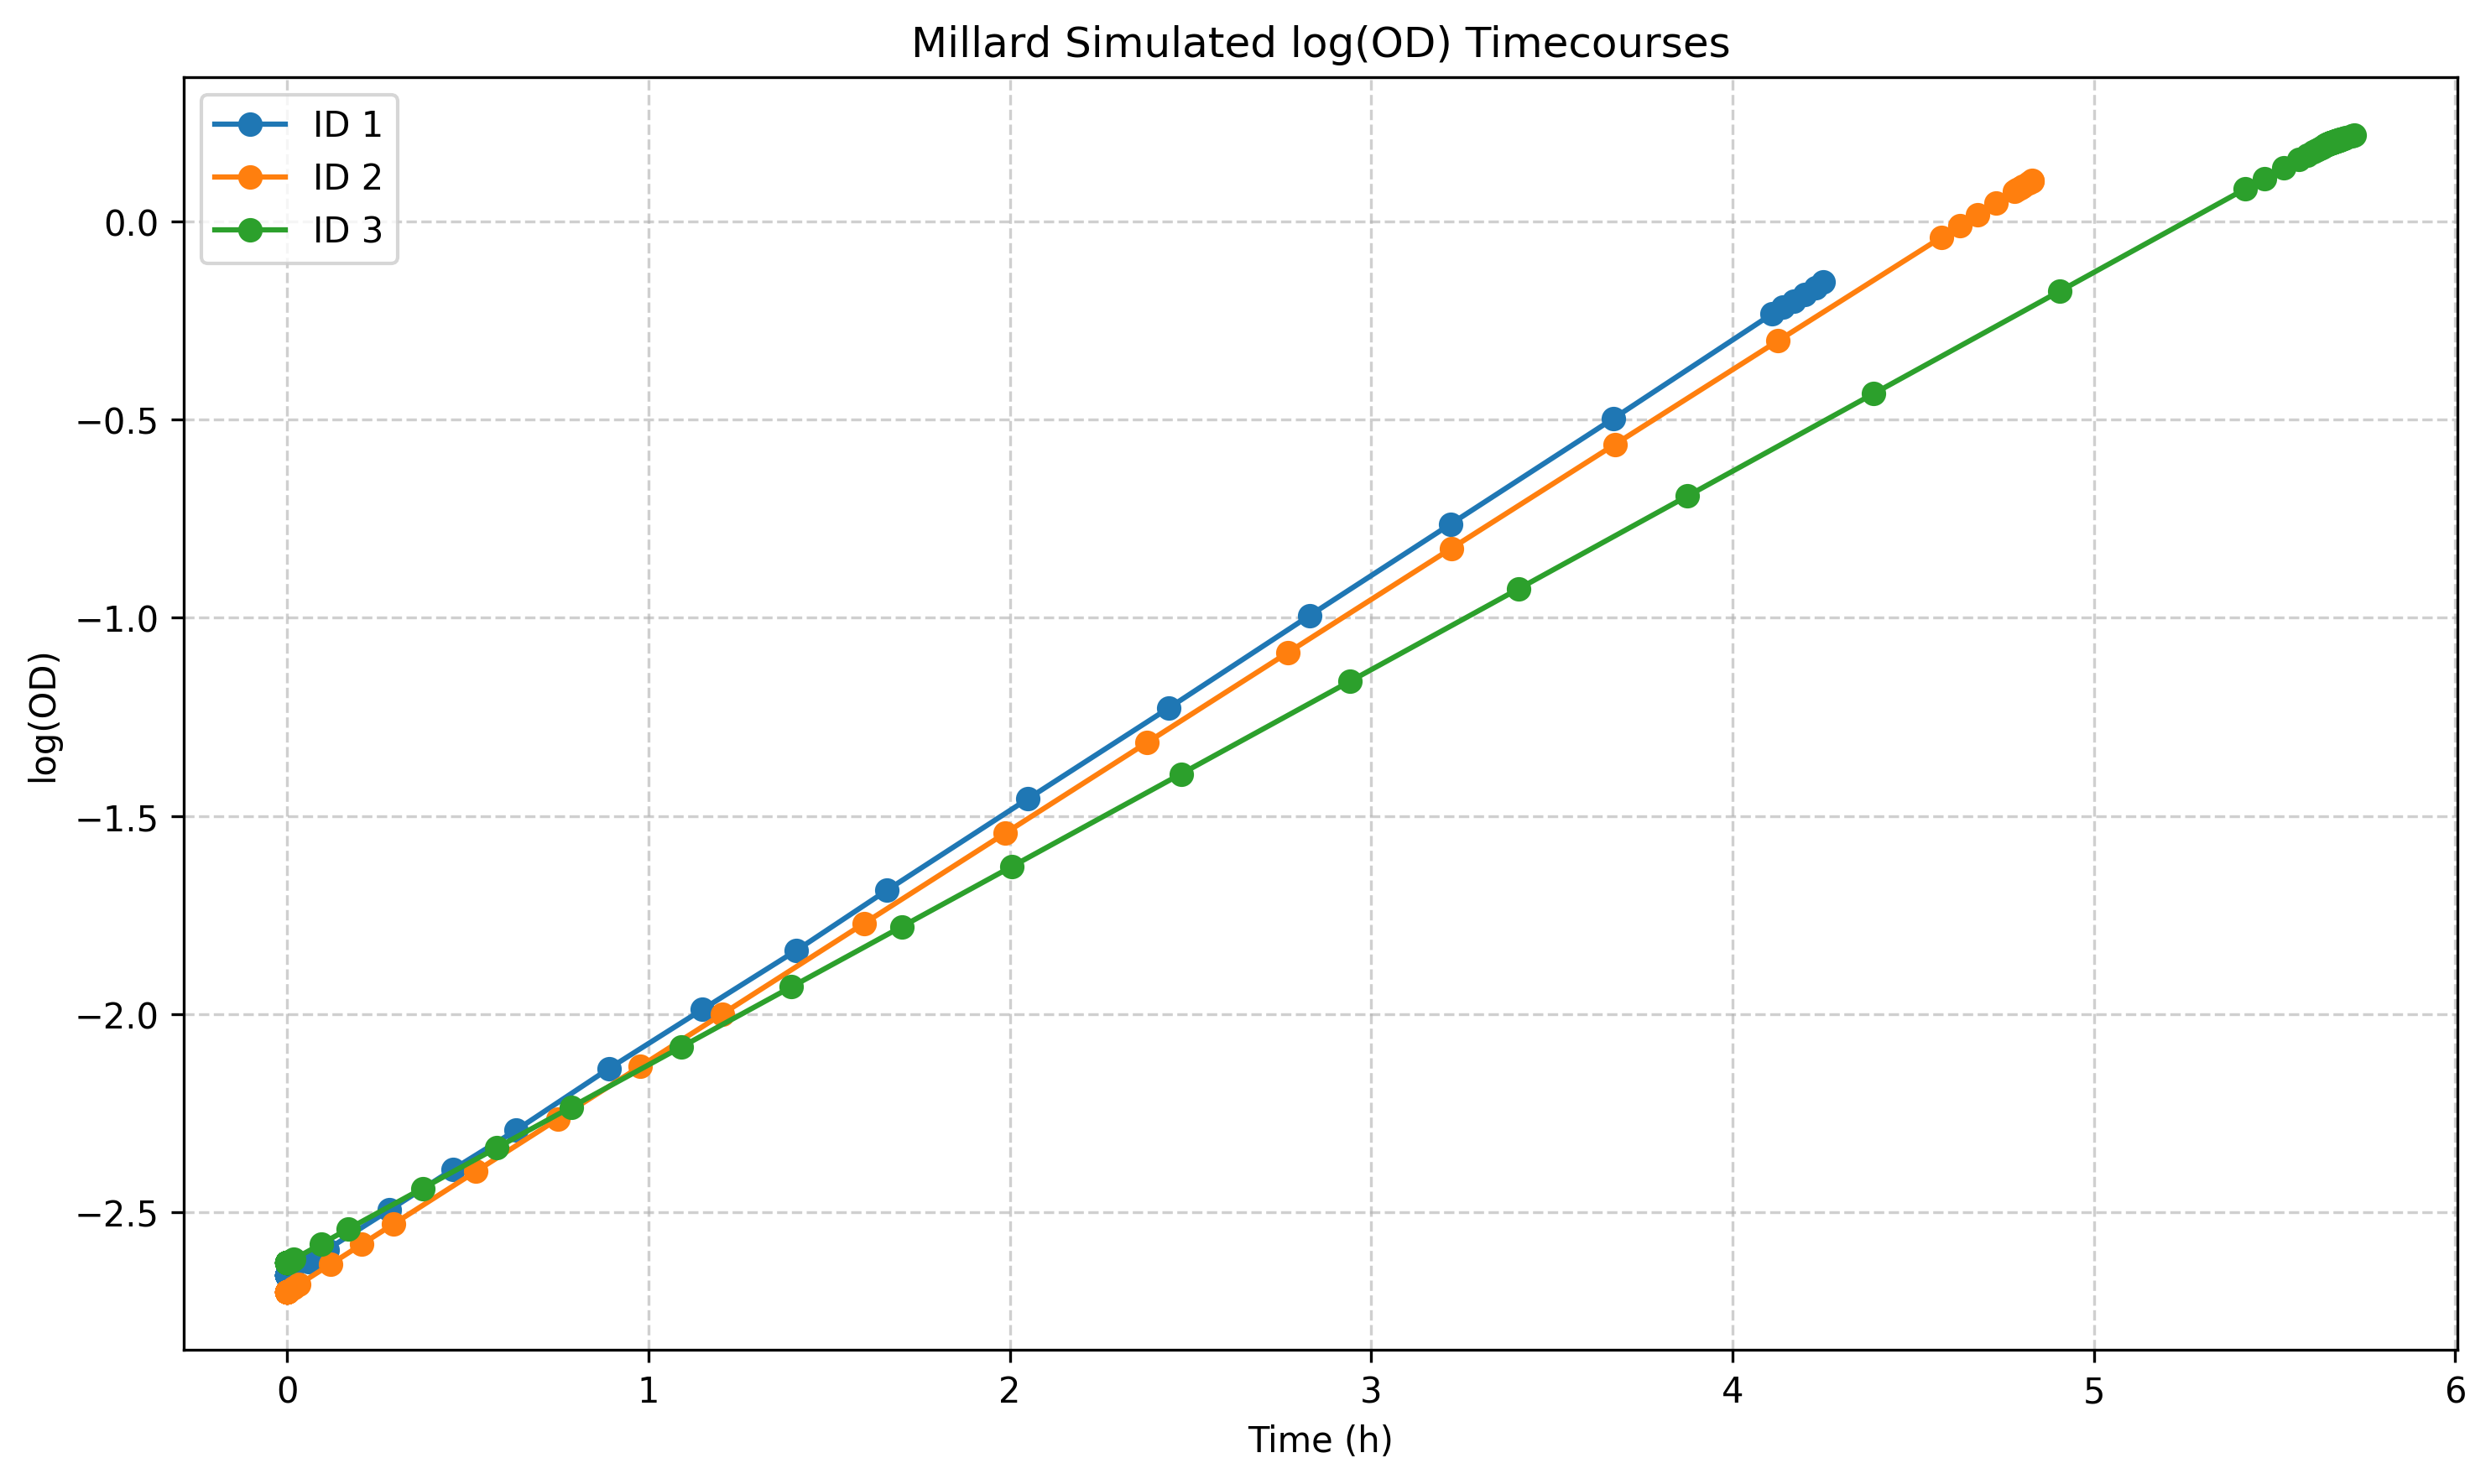

In [3]:

# Finalize the media DataFrame and order columns
media_df = pd.DataFrame(media_rows)
media_df = media_df[['ID'] + paul_metabolites]

# Save results
media_df.to_csv("Millard_media_converted.csv", index=False)
od_df_combined.to_csv("Millard_OD_converted.csv", index=False)

# Load the OD file
od_df = pd.read_csv("Millard_OD_converted.csv")

# List experiment IDs to plot
experiment_ids = [1, 2, 3]

# Plot
plt.figure(figsize=(10, 6), dpi=300)
for exp_id in experiment_ids:
    time_col = f'T_{exp_id}'
    od_col = f'OD_{exp_id}'
    
    if time_col in od_df.columns and od_col in od_df.columns:
        od_df_clean = od_df[[time_col, od_col]].dropna()
        plt.plot(od_df_clean[time_col], od_df_clean[od_col],
                 label=f'ID {exp_id}', marker='o')

plt.xlabel('Time (h)')
plt.ylabel('log(OD)')
plt.title('Millard Simulated log(OD) Timecourses')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
from scipy.interpolate import interp1d

# Define the target time grid (uniform, e.g., 20 points between 0 and 5 hours)
common_times = np.linspace(0.0, 5.0, 20)

# Files to process
files = {
    "1mM": "Millard_data_1mM_formated.csv",
    "10mM": "Millard_data_10mM_formated.csv",
    "30mM": "Millard_data_30mM_formated.csv"
}

# Interpolated results
interpolated_data = {}

for label, file in files.items():
    df = pd.read_csv(file)

    # Set up interpolation functions for each column (excluding 'T')
    interp_funcs = {
        col: interp1d(df['T'], df[col], kind='linear', fill_value='extrapolate')
        for col in df.columns if col != 'T'
    }

    # Build interpolated DataFrame
    interp_df = pd.DataFrame({'T': common_times})
    for col, f in interp_funcs.items():
        interp_df[col] = f(common_times)

    interpolated_data[label] = interp_df
    # Optionally save the result
    interp_df.to_csv(f"Millard_data_{label}_interpolated.csv", index=False)

In [5]:

# Load Paul media to extract full set of metabolites
paul_media = pd.read_csv("Paul_media.csv")
paul_metabolites = list(paul_media.columns[1:])  # exclude 'ID'

# Interpolated files (assumed to exist)
files = {
    1: "Millard_data_1mM_interpolated.csv",
    2: "Millard_data_10mM_interpolated.csv",
    3: "Millard_data_30mM_interpolated.csv"
}

media_rows = []
od_df_combined = pd.DataFrame()

for exp_id, file in files.items():
    df = pd.read_csv(file)
    initial = df.iloc[0]

    # Create media dictionary (fill missing metabolites with 0)
    media_dict = {
        'ID': exp_id,
        'glc__D_e': initial['GLC'],
        'acet_e': initial['ACE_env'],
        'accoa_c': initial['ACCOA'],
        'acp_c': initial['ACP'],
        'ac_c': initial['ACE_cell'],
    }
    for met in paul_metabolites:
        if met not in media_dict:
            media_dict[met] = 0.0
    media_rows.append(media_dict)

    # OD block: log-transform biomass (X)
    t_col = f'T_{exp_id}'
    od_col = f'OD_{exp_id}'
    dev_col = f'DEV_{exp_id}'

    tmp_df = pd.DataFrame({
        t_col: df['T'],
        od_col: np.log(df['X'] + 1e-8),  # log(OD)
        dev_col: np.zeros_like(df['X'])  # no deviation known
    })

    tmp_df.reset_index(drop=True, inplace=True)
    od_df_combined = pd.concat([od_df_combined, tmp_df], axis=1)

# Finalize DataFrames
media_df = pd.DataFrame(media_rows)
media_df = media_df[['ID'] + paul_metabolites]

# Optionally save
media_df.to_csv("Millard_media_from_interpolated.csv", index=False)
od_df_combined.to_csv("Millard_OD_from_interpolated.csv", index=False)